# HR Analytics – Predict Employee Attrition

**Objective:**  
Predict which employees are likely to leave the company using HR data.  
Understand key factors driving attrition and provide actionable insights.

**Tools Used:**  
- Python (Pandas, Seaborn, Scikit-learn, SHAP)  
- Power BI (for dashboard with cleaned data)

---


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler


In [3]:
# Load dataset
df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')  # Change path if needed
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Initial Data Inspection

- Check basic info  
- Check for missing values  
- Check target variable distribution


In [4]:
print(df.info())
print(df.isnull().sum())
print(df['Attrition'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Exploratory Data Analysis (EDA)

We analyze attrition distribution overall and by key HR features like Department, Monthly Income, Promotions, and Overtime.


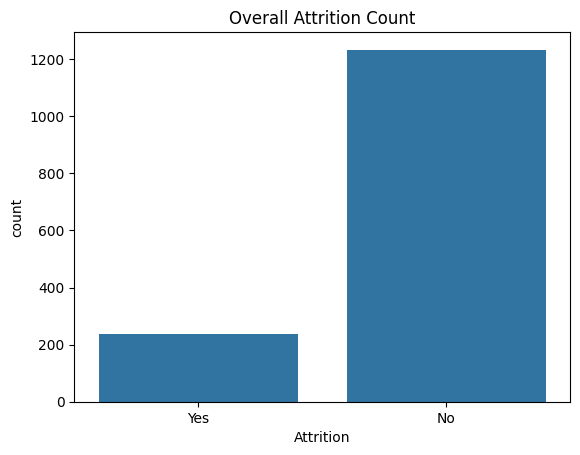

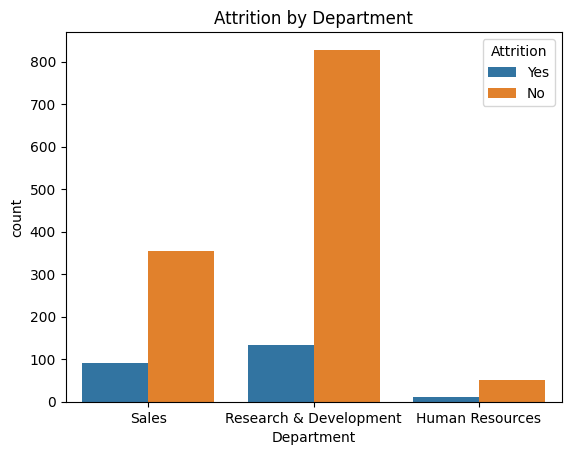

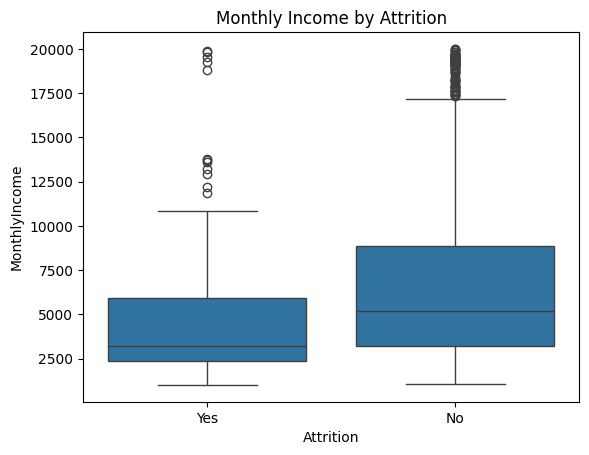

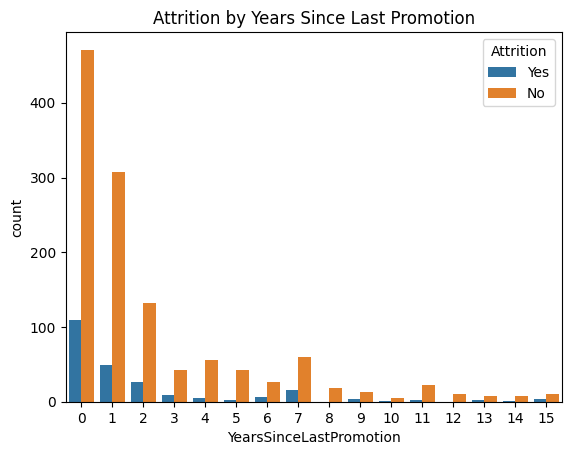

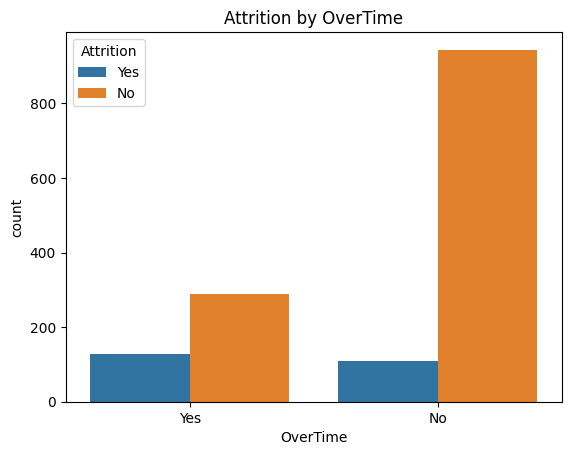

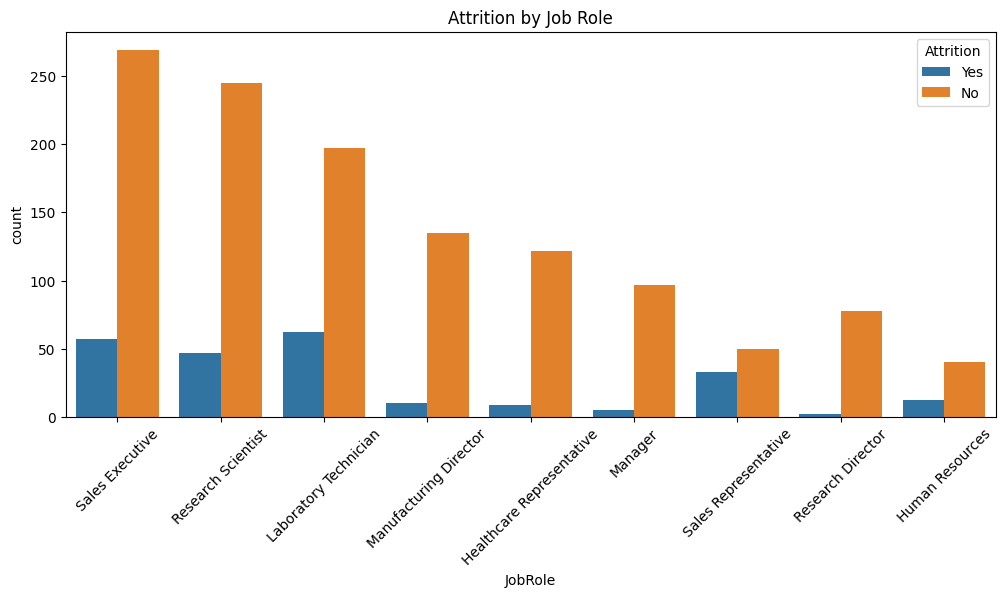

In [5]:
# Overall Attrition count
sns.countplot(x='Attrition', data=df)
plt.title('Overall Attrition Count')
plt.show()

# Attrition by Department
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Attrition by Department')
plt.show()

# Monthly Income by Attrition
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income by Attrition')
plt.show()

# Attrition by Years Since Last Promotion
sns.countplot(x='YearsSinceLastPromotion', hue='Attrition', data=df)
plt.title('Attrition by Years Since Last Promotion')
plt.show()

# Attrition by OverTime
sns.countplot(x='OverTime', hue='Attrition', data=df)
plt.title('Attrition by OverTime')
plt.show()

# Attrition by Job Role
plt.figure(figsize=(12,5))
sns.countplot(x='JobRole', hue='Attrition', data=df)
plt.xticks(rotation=45)
plt.title('Attrition by Job Role')
plt.show()


## Correlation Analysis & Age Group Analysis


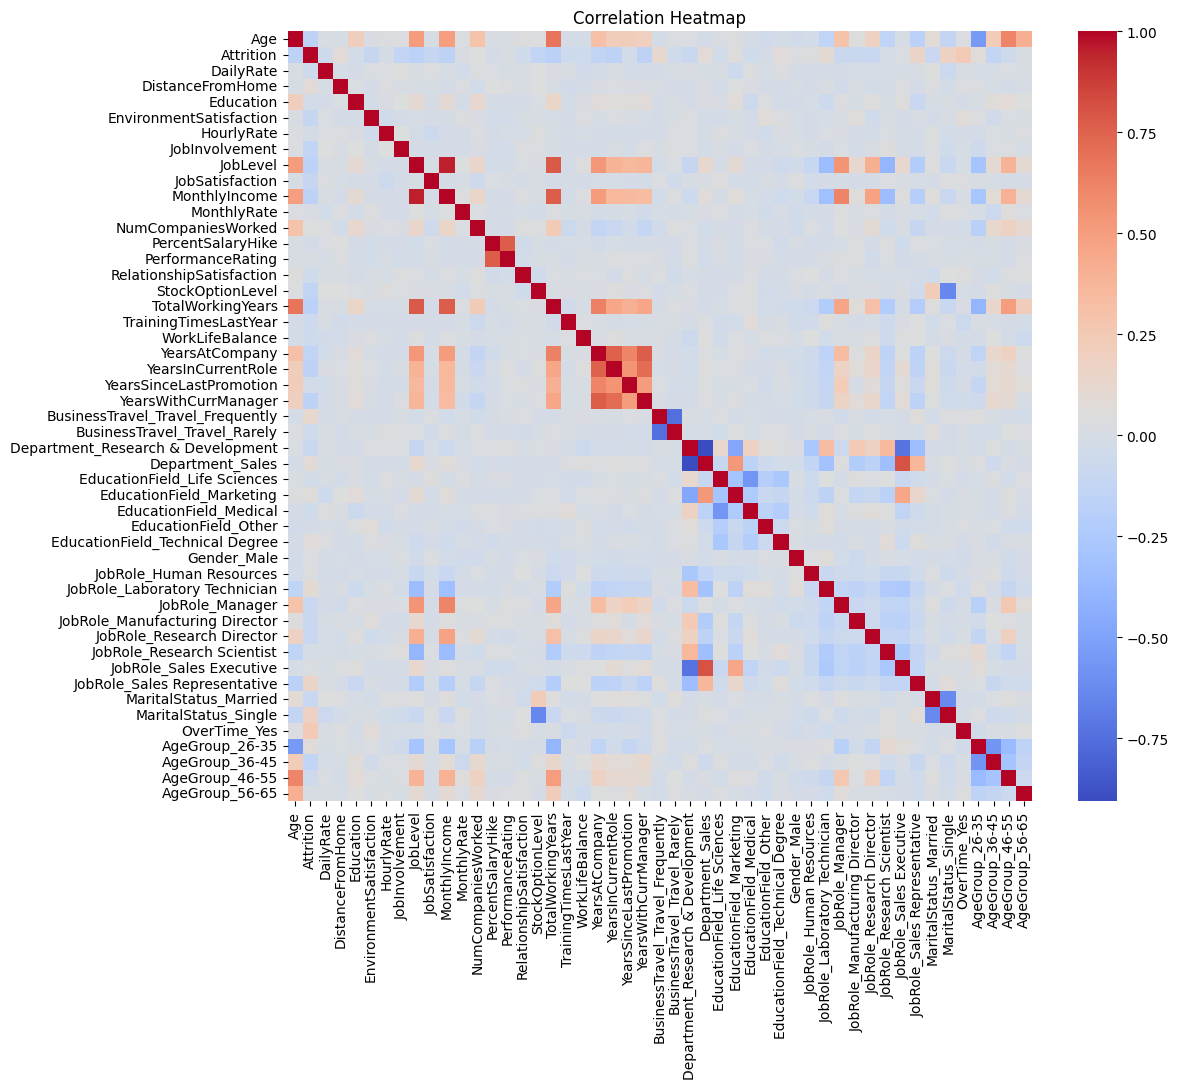

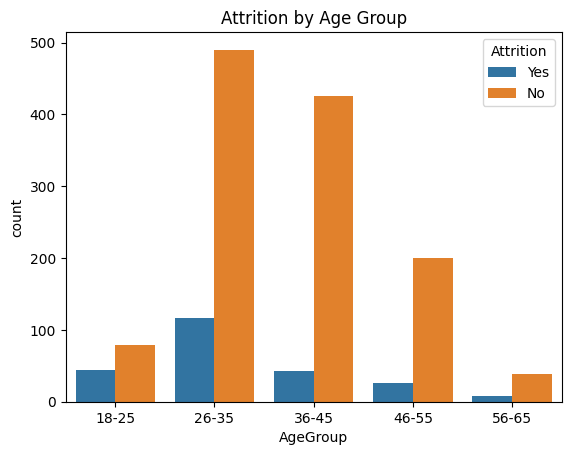

In [9]:
# Correlation heatmap (numeric features only)
plt.figure(figsize=(12,10))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Create AgeGroup for better visualization
df['AgeGroup'] = pd.cut(df['Age'], bins=[17,25,35,45,55,65],
                        labels=['18-25','26-35','36-45','46-55','56-65'])

sns.countplot(x='AgeGroup', hue='Attrition', data=df)
plt.title('Attrition by Age Group')
plt.show()

## Data Preprocessing

- Drop irrelevant columns  
- Encode target variable  
- One-hot encode categorical variables  
- Scale numerical features  


In [8]:
# Drop irrelevant columns
df_cleaned = df.drop(['EmployeeNumber', 'StandardHours', 'EmployeeCount', 'Over18'], axis=1)

# Encode target variable
df_cleaned['Attrition'] = df_cleaned['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
            'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
            'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
            'YearsSinceLastPromotion', 'YearsWithCurrManager']

df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])


## Prepare Data for Model Training

- Separate features (X) and target (y)  
- Split into training and test sets  


In [10]:
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Model Building: Logistic Regression

Train Logistic Regression on the training data.


In [11]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

## Model Evaluation: Logistic Regression


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       380
           1       0.59      0.36      0.45        61

    accuracy                           0.88       441
   macro avg       0.75      0.66      0.69       441
weighted avg       0.86      0.88      0.86       441

Confusion Matrix:
 [[365  15]
 [ 39  22]]
ROC AUC Score: 0.8161777394305435


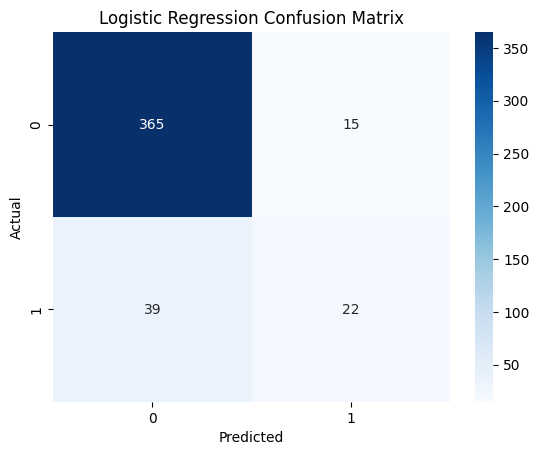

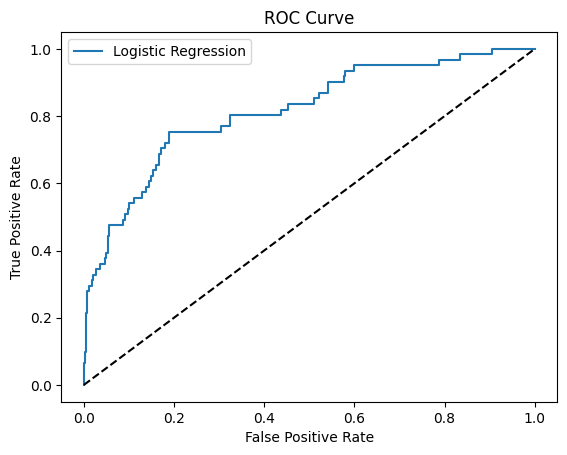

In [12]:
y_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Model Building: Decision Tree (for comparison)


In [13]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)

y_pred_tree = model_tree.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       380
           1       0.32      0.38      0.35        61

    accuracy                           0.80       441
   macro avg       0.61      0.63      0.62       441
weighted avg       0.82      0.80      0.81       441



## Hyperparameter Tuning: Decision Tree


In [14]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

best_tree = grid_search.best_estimator_
y_pred_best_tree = best_tree.predict(X_test)

print("Tuned Decision Tree Classification Report:\n", classification_report(y_test, y_pred_best_tree))


Best parameters found: {'max_depth': 3, 'min_samples_split': 2}
Tuned Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       380
           1       0.75      0.10      0.17        61

    accuracy                           0.87       441
   macro avg       0.81      0.55      0.55       441
weighted avg       0.86      0.87      0.83       441



## Feature Importance (Explainability)


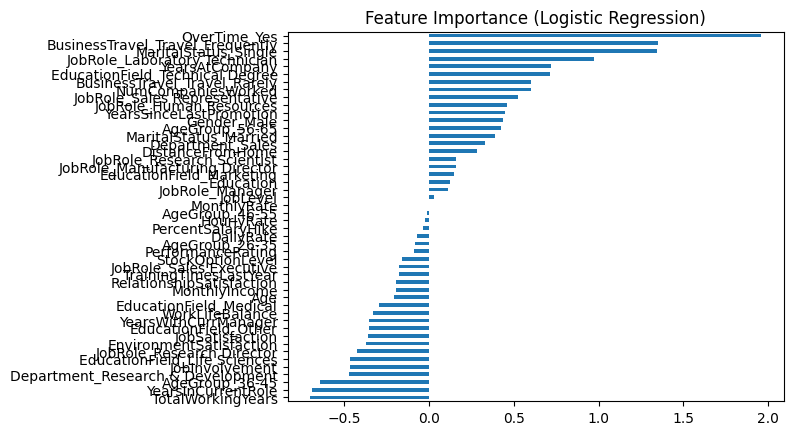

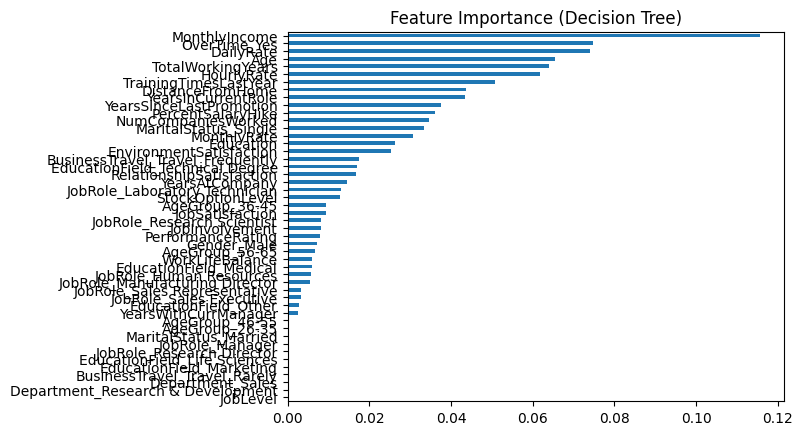

In [39]:
# For Logistic Regression
feature_importance = pd.Series(model_lr.coef_[0], index=X_train.columns)
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

# For Decision Tree
tree_importance = pd.Series(model_tree.feature_importances_, index=X_train.columns)
tree_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance (Decision Tree)')
plt.show()


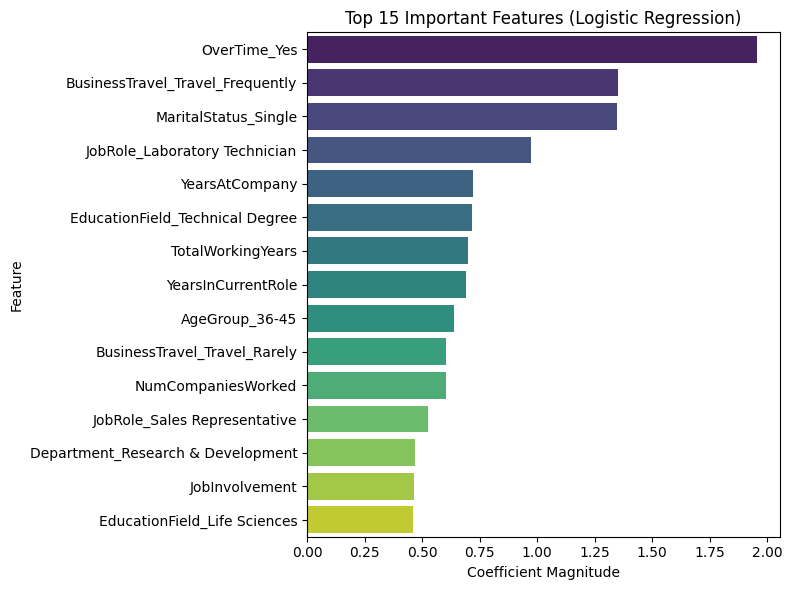

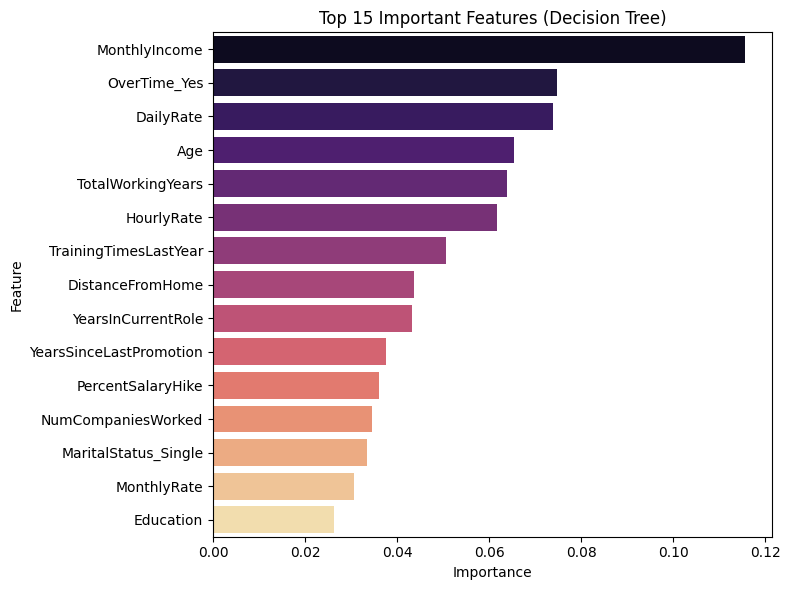

In [41]:
# For Logistic Regression - top 15 important features only, nicely styled
feature_importance = pd.Series(model_lr.coef_[0], index=X_train.columns)
top_features = feature_importance.abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features, y=top_features.index, palette='viridis')
plt.title('Top 15 Important Features (Logistic Regression)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# For Decision Tree - top 15 important features only
tree_importance = pd.Series(model_tree.feature_importances_, index=X_train.columns)
top_tree_features = tree_importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_tree_features, y=top_tree_features.index, palette='magma')
plt.title('Top 15 Important Features (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [44]:
!pip install shap


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Load your cleaned dataset
df = pd.read_csv("/content/hr_cleaned.csv")  # Or whatever your final cleaned DataFrame is

# 2. Separate target and features
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 3. Encode categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

# Use LabelEncoder or OneHotEncoder
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# 4. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)


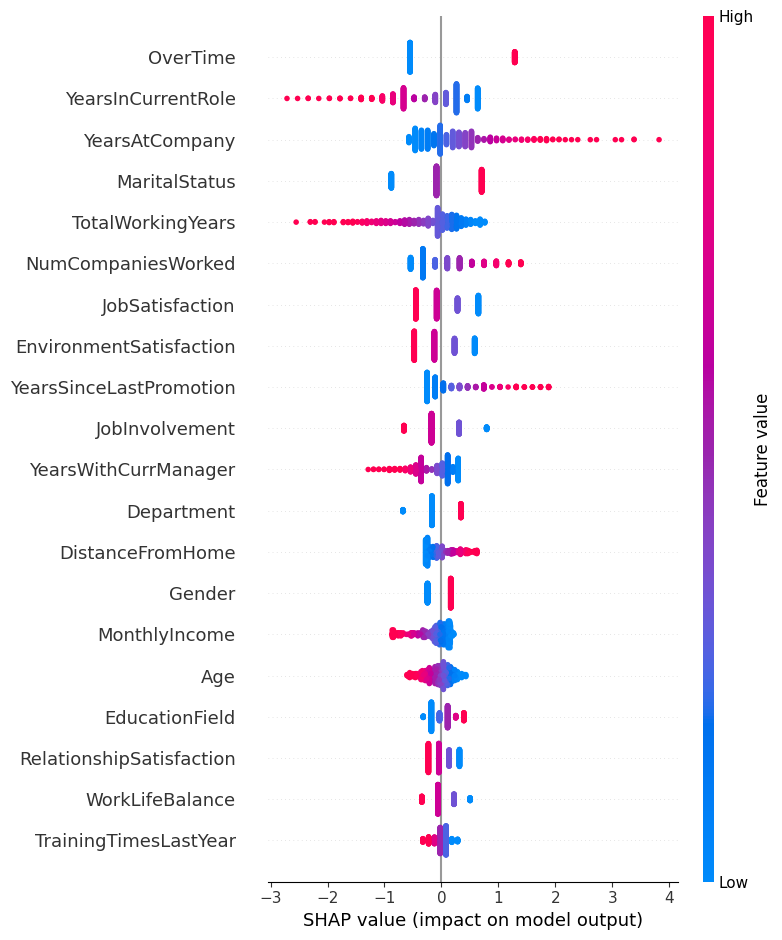

In [49]:
import shap
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Train model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(model_lr, X_train)
shap_values = explainer(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)


In [50]:
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
plt.close()


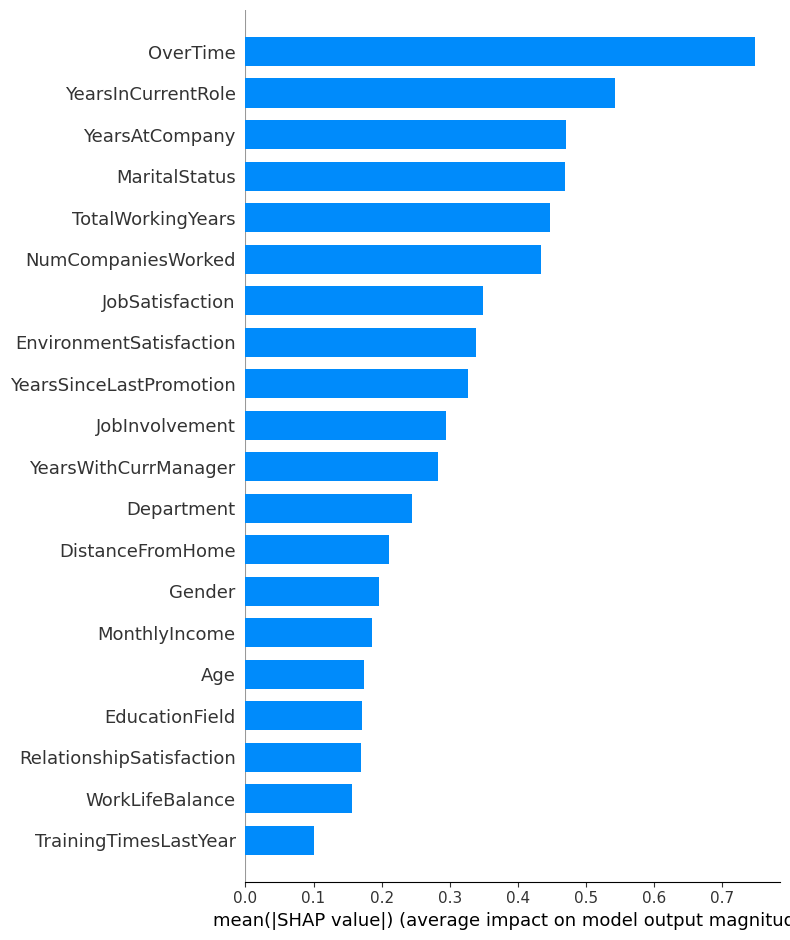

<Figure size 640x480 with 0 Axes>

In [53]:
import shap
import matplotlib.pyplot as plt

# Assuming you already have the SHAP values and feature names from earlier
shap_values = explainer.shap_values(X_test)  # or X_val, X depending on your use
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Save it
plt.savefig("shap_feature_importance.png", bbox_inches='tight')


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_acc = lr_model.score(X_test, y_test)
print(f"Logistic Regression Accuracy: {lr_acc:.2f}")

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_acc = dt_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_acc:.2f}")


Logistic Regression Accuracy: 0.87
Decision Tree Accuracy: 0.79


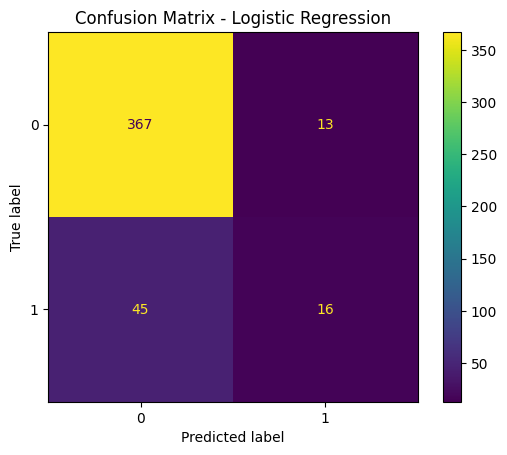

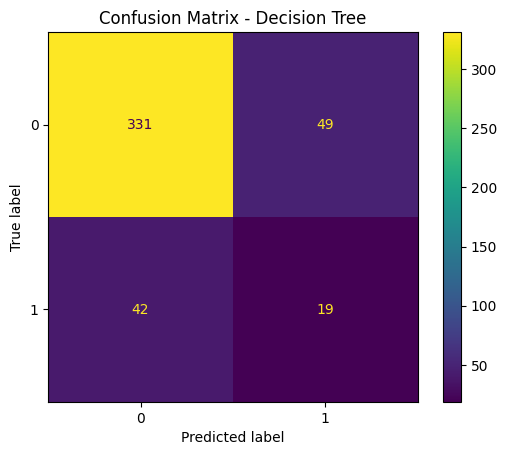

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LR
lr_preds = lr_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# DT
dt_preds = dt_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, dt_preds)
plt.title("Confusion Matrix - Decision Tree")
plt.show()


In [59]:
import joblib
joblib.dump(dt_model, "attrition_model.pkl")


['attrition_model.pkl']

## Save Cleaned Data for Power BI Dashboard

Export the cleaned and preprocessed data so you can create rich visual dashboards in Power BI.


In [51]:
df_cleaned.to_csv('hr_cleaned.csv', index=False)

# If in Colab, download:
#from google.colab import files
#files.download('hr_cleaned.csv')


## ✅ Conclusion

- Built predictive models for attrition (Logistic Regression & Decision Tree)
- Identified key drivers: Overtime, Income, Promotions, etc.
- Created cleaned dataset for Power BI dashboard
- Final deliverables:
  - Power BI dashboard
  - Confusion matrix & report
  - PDF of prevention suggestions

